![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+Forecasting&file=BigQuery+Time+Series+Forecasting+Data+Review+and+Preparation.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520Forecasting%2FBigQuery%2520Time%2520Series%2520Forecasting%2520Data%2520Review%2520and%2520Preparation.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20Forecasting/BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Time Series Forecasting - Data Review in BigQuery

This is the first notebook in the series for [Applied Forecasting](./readme.md)!  This notebook will look at a data source with a time element, a demand signal over time, and covariates that impact demand.  The details of methods used to explores and prepare the data for use in all other notebooks in this series will be covered.  A core concept in data review for forecasting is visualizing trends over time which will be developed here using [Plotly](https://plotly.com/python/) and [matplotlib](https://matplotlib.org/). Visualazations developed here are reused and extended in the other notebooks.

**Data Source: Citibike rentals in New York City**

This series uses Citibike rentals in New York city.  The bike stations near central park will be selected and the daily number bike trips that orignate from these stations will be followed over time.  This will illustrate some common forecasting issues due to new stations being introduced over time and some stations only have the most recent few months, or just weeks of data.  The data are found in the BigQuery Public datasets at: 
- `bigquery-public-data.new_york.citibike_trips`
- `bigquery-public-data.new_york.citibike_stations`

---

**Series Overview**

[This series](./readme.md) explores forecasting with Vertex AI, BigQuery ML, and additional open source frameworks.  Forecasting consist of following a measurement over time and exploring trends, the impact of seasonality (years, months, days, etc), holidays, and special events with the hope of using these insights to forecast into the near future.  Some method also incoporate observable measurements that impact demand to understand the relationships and make forecasting more accurate.

---

**Prerequisites:**
-  None from this repository

**Resources:**
- [BigQuery](https://cloud.google.com/bigquery/docs/introduction)
    - [BigQuery Python Client](https://cloud.google.com/python/docs/reference/bigquery/latest)
    - [SQL Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax)
- Blog: [How to do time series forecasting in BigQuery](https://towardsdatascience.com/how-to-do-time-series-forecasting-in-bigquery-af9eb6be8159)
- Using BigQuery From Python, Notebooks in This Repository:
    - [Tips/BigQuery - Python Client](../Tips/BigQuery%20-%20Python%20Client.ipynb)
    - [01 - Data Sources/01 - BigQuery - Table Data Sources](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb)
    - [03 - BigQuery ML (BQML)/Introduction to BigQuery ML (BQML)](../03%20-%20BigQuery%20ML%20(BQML)/Introduction%20to%20BigQuery%20ML%20(BQML).ipynb)   

**Conceptual Flow & Workflow**
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/afore1_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/afore1_console.png" width="45%">
</p>

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [2]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [3]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs and API Enablement

The clients packages may need installing in this environment. 

### Installs (If Needed)

In [4]:
# tuples of (import name, install name)
packages = [
    ('plotly', 'plotly'),
    ('kaleido', 'kaleido')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [5]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Setup

inputs:

In [6]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [7]:
REGION = 'us-central1'
EXPERIMENT = 'forecasting-data'
SERIES = 'applied-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = EXPERIMENT

viz_limit = 12

packages:

In [60]:
from google.cloud import bigquery

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

clients:

In [10]:
bq = bigquery.Client(project = PROJECT_ID)

---
## Data Setup

### Create BigQuery Dataset
Create a BigQuery Dataset within this project if missing:
- [Reference](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.dataset.Dataset.html#google.cloud.bigquery.dataset.Dataset)

In [11]:
ds = bigquery.Dataset(f"{PROJECT_ID}.{BQ_DATASET}")
ds.location = 'us' #Multi-region is REGION[0:2]
ds.labels = {'notebook': f"{EXPERIMENT}"}
ds = bq.create_dataset(dataset = ds, exists_ok = True)

In [12]:
ds.dataset_id

'applied_forecasting'

In [13]:
ds.full_dataset_id

'statmike-mlops-349915:applied_forecasting'

List BigQuery datasets in the project:

In [14]:
datasets = list(bq.list_datasets())
for d in datasets:
    print(d.dataset_id)

BQML
applied_forecasting
applied_forecasting_pipeline_bqml_arimaplus
applied_genai
applied_genai_v2
bigframes_temp_us
bigframes_temp_us_central1
bqml
bqml_remote_model_tutorial
crossvalidation
explained_columns
feature_engineering
forecasting_8_tournament
forecasting_demo_prophet_vw3eqr84
fraud
github_api
model_deployment_monitoring_5876762107113897984
tmp_4126828053735145472_2023_12_13T17_40_00_684Z
working_with_docai


### Review Source Data
Stored in BigQuery Public Datasets

Quick Preview:

In [15]:
query = f"""
    SELECT * 
    FROM `bigquery-public-data.new_york.citibike_trips`
    LIMIT 5
"""
bq.query(query).to_dataframe()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,1335,2016-07-23 10:16:35+00:00,2016-07-23 10:38:51+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,520,W 52 St & 5 Ave,40.759923,-73.976485,24865,Subscriber,1989,male
1,1491,2016-07-26 11:44:14+00:00,2016-07-26 12:09:05+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,520,W 52 St & 5 Ave,40.759923,-73.976485,25903,Subscriber,1989,male
2,609,2016-09-24 07:51:17+00:00,2016-09-24 08:01:27+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,3102,Driggs Ave & Lorimer St,40.721791,-73.950415,25001,Subscriber,1972,male
3,2245,2016-08-28 16:06:06+00:00,2016-08-28 16:43:32+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,416,Cumberland St & Lafayette Ave,40.687534,-73.972652,26015,Subscriber,1975,male
4,1474,2016-06-25 09:56:38+00:00,2016-06-25 10:21:12+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,305,E 58 St & 3 Ave,40.760958,-73.967245,23305,Customer,<NA>,unknown


In [16]:
query = f"""
    SELECT * 
    FROM `bigquery-public-data.new_york.citibike_stations`
    LIMIT 5
"""
bq.query(query).to_dataframe()

,station_id,name,short_name,latitude,longitude,region_id,rental_methods,capacity,eightd_has_key_dispenser,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,eightd_has_available_keys,last_reported
0,495,W 47 St & 10 Ave,6824.07,40.762699,-73.993012,71,"KEY, CREDITCARD",0,False,0,0,0,0,True,True,True,False,1970-01-02 00:00:00+00:00
1,3171,Amsterdam Ave & W 82 St,7360.10,40.785247,-73.976673,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
2,3603,31 Ave & 30 St,6857.09,40.764700,-73.924031,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
3,3733,Avenue C & E 18 St,5769.04,40.730563,-73.973984,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
4,3792,Columbus Dr at Exchange Pl,JC106,40.716870,-74.032810,70,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00


Review miss-matches in station names between the two source tables:

In [17]:
query = """
    WITH
        STATIONS AS (
            SELECT distinct name as stations
            FROM `bigquery-public-data.new_york.citibike_stations`
            WHERE name LIKE '%Central Park%'
        ),
        TRIPS AS (
            SELECT distinct start_station_name as trips
            FROM `bigquery-public-data.new_york.citibike_trips`
            WHERE start_station_name LIKE '%Central Park%'   
        )
    SELECT *
    FROM STATIONS a
    FULL JOIN TRIPS b
    on a.stations = b.trips
"""
bq.query(query).to_dataframe()

,stations,trips
0,Central Park W & W 91 St,None
1,Central Park S & 6 Ave,Central Park S & 6 Ave
2,None,Central Park West & W 100 St
3,Central Park W & W 103 St,None
4,Central Park West & W 76 St,Central Park West & W 76 St
5,None,Central Park W & W 96 St
6,W 106 St & Central Park West,W 106 St & Central Park West
7,Central Park West & W 85 St,Central Park West & W 85 St
8,Grand Army Plaza & Central Park S,Grand Army Plaza & Central Park S
9,Central Park West & W 72 St,Central Park West & W 72 St


### Create a Source Table or View
It is common to need to combine multiple sources together to bring together all the data needed for forecasting.  Here, multiple source tables are referenced to create a combined forecasting source table.

The goal is one row per time point for each time series.  The means aggregating the transaction to a demand signal for each time series and each time point (day, month, quarter, ...).

If all of the data needed for forecasting is already prepared then a statement like this might not be needed.  Adapting this code to your situation it could be a simple as:

```SQL
CREATE OR REPLACE VIEW `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source` AS
SELECT *
FROM {BQ_SOURCE}
```

In [18]:
# CUSTOMIZE
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source` AS
WITH
    STATION AS (
        SELECT
           start_station_name,
           EXTRACT(DATE FROM starttime) AS starttime,
           COUNT(*) AS num_trips,
           AVG(tripduration) as avg_tripduration,
           COUNTIF(usertype='Subscriber')/COUNT(*) as pct_subscriber,
           SAFE_DIVIDE(COUNTIF(gender='male'), COUNTIF(gender!='male')) as ratio_gender
        FROM `bigquery-public-data.new_york.citibike_trips`
        WHERE start_station_name LIKE '%Central Park%'
        GROUP BY start_station_name, starttime
    ),
    STATION_INFO AS (
        SELECT
            name,
            max(capacity) as capacity
        FROM `bigquery-public-data.new_york.citibike_stations`
        WHERE name LIKE '%Central Park%'
        GROUP BY name
    )
SELECT * EXCEPT(name)
FROM STATION A
LEFT OUTER JOIN STATION_INFO B
ON A.start_station_name = B.name
ORDER BY start_station_name, starttime
"""
job = bq.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

4.347

In [19]:
print(f'Review The Source Data in The BigQuery Console:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!4m3!1s{BQ_PROJECT}!2s{BQ_DATASET}!3s{BQ_TABLE}_source&pli=1')

Review The Source Data in The BigQuery Console:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!4m3!1sstatmike-mlops-349915!2sapplied_forecasting!3sforecasting-data_source&pli=1


### Prepare Data for Forecasting

Parameters and common queries used for [cte](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#simple_cte).

**Univariate Forecasting** consists of just 2 columns per time series:
- `TARGET_COLUMN` = The demand measurment.
    In our case it is the number of trips taken per day from a particular bike station - the sum of trips for a day.
- `TIME_COLUMN` = The time of demand.
    Expressed in the time or date units related to the granularity of the forecast exercise.  In our case, demand is measured daily so the time column is prepared as a date. 

**Additional Columns** are used to instruct the forecasting algorithms handling of the data:
- `SERIES_COLUMN` groups rows associated with the same time series.
    - Conducting multiple forecasts, one per time series, means including a third column to capture the groups of row for each time series: `SERIES_COLUMN`. 
    - **NOTE:** BigQuery ARIMA+ fits a separate forecast for each of these groups.  In our case this is the `start_station_name` which is the name for each individual Citibike station near Central Park.
- `SPLITS_COLUMN` groups sequential rows within each time series for their purpose during the forecasting exercise.
    - This data was prepared with splits for `TRAIN`, `VALIDATE` and `TEST` in the prerequisite notebooks.  The column that contains these splits can be used by the choosen forecast method during training rather than have the method calculate the splits.  This can be helpful when comparing multiple different methods as it ensures splitting is handled the same across each method.
- `COVARIATE_COLUMNS` is a list of columns that measure additional features over time.  Some forcasting methods can use these to imporove the understanding of trends and make better forecasts.  Univarate forecast methods will not use these.  To use a covariate for forecasting then its value needs to be know in advance to be used when making predictions, or the forecast method will need to have special handling for unknown covariates.  The three types of covariate information are:
    - Attributes
        - Values that do not change over time but describe what the time series represents.  In our case a bike station might be identified by latitude and longitude, color, number of bike slots.
    - Covariates that are available at forecast time (in advance)
        - These are measurements that can be known ahead of time like when holidays occur, promotions, events, changes in capacity.
    - Covariates that are unavailable at forecast time (in advance)
        - Measurements that change over time but are not known until the time of measurment like rain, other weather, foot traffic, and queue length.

In [20]:
# CUSTOMIZE THIS CELL
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
SPLIT_COLUMN = 'splits'
COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender', 'capacity'] # could be empty

Quick Summary of Series with totals and date ranges for each series:

In [21]:
query = f"""
    SELECT {SERIES_COLUMN}, sum({TARGET_COLUMN}) as {TARGET_COLUMN}, min({TIME_COLUMN}) as FromDate, max({TIME_COLUMN}) as ToDate
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
overview = bq.query(query).to_dataframe()
overview.head(viz_limit)

,start_station_name,num_trips,FromDate,ToDate
0,Central Park North & Adam Clayton Powell Blvd,4808,2016-09-01,2016-09-30
1,Central Park S & 6 Ave,172220,2013-07-01,2016-09-30
2,Central Park W & W 96 St,5905,2016-08-04,2016-09-30
3,Central Park West & W 100 St,2245,2016-08-08,2016-09-30
4,Central Park West & W 102 St,2851,2016-08-08,2016-09-30
5,Central Park West & W 68 St,35192,2015-09-01,2016-09-30
6,Central Park West & W 72 St,44574,2015-09-01,2016-09-30
7,Central Park West & W 76 St,27919,2015-09-09,2016-09-30
8,Central Park West & W 85 St,43895,2015-10-07,2016-09-23
9,Grand Army Plaza & Central Park S,163815,2013-07-01,2016-09-30


Visualize each series date/time range:

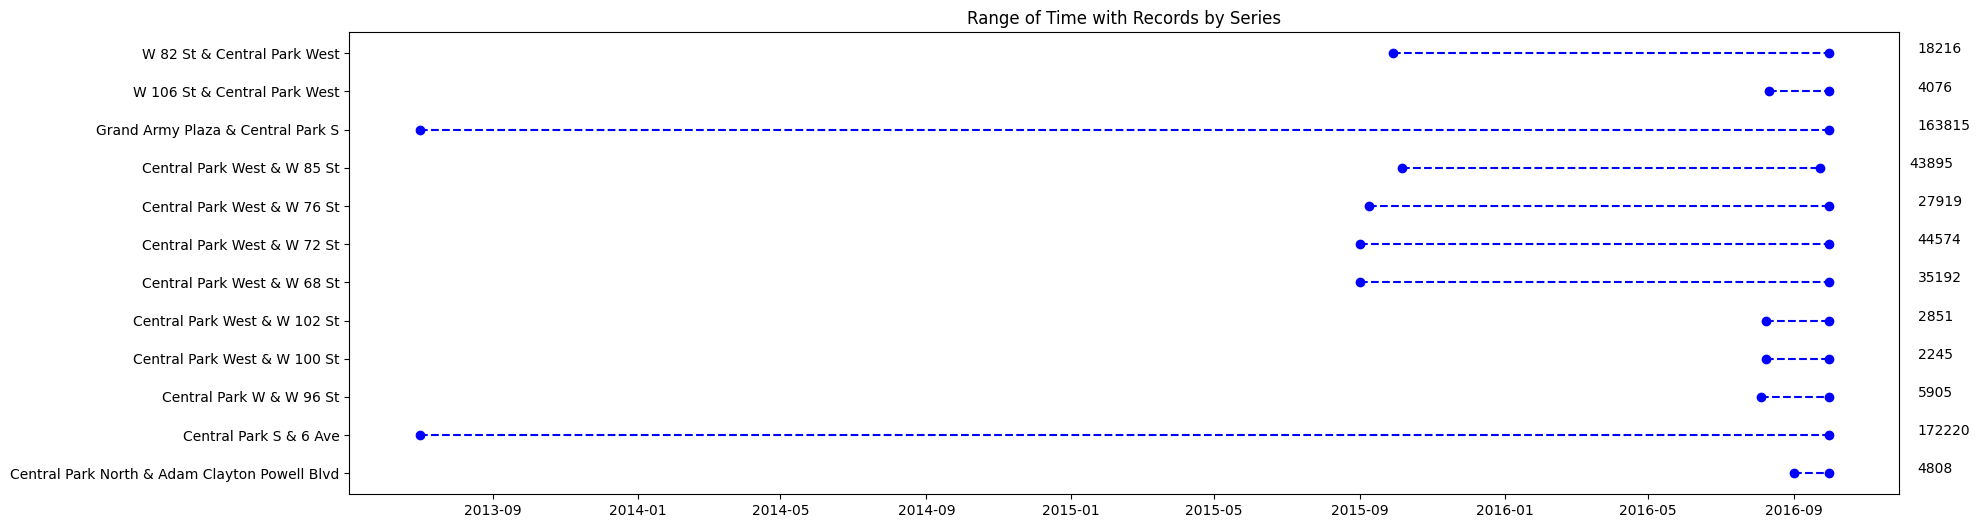

In [22]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records by Series')
plt.show()

Overlay the dates with data onto the plot to understand any gaps in data for the series:

In [23]:
query = f"""
    SELECT DISTINCT {SERIES_COLUMN}, {TIME_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
dates = bq.query(query).to_dataframe()

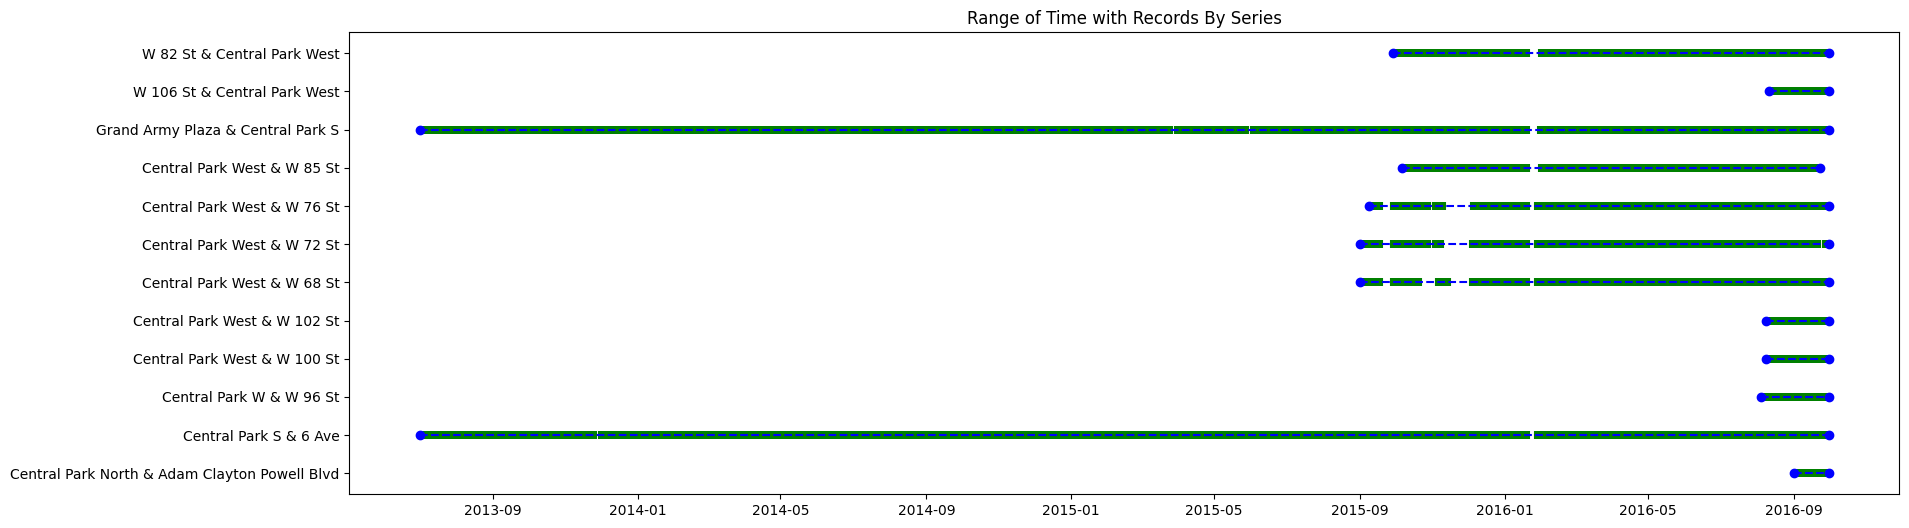

In [24]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    # subset dates to current series and plot dates with records on timelines for each series:
    tempdates = dates[(dates[SERIES_COLUMN] == overview[SERIES_COLUMN][i])]
    plt.scatter(tempdates[TIME_COLUMN], tempdates[SERIES_COLUMN], c='g', marker='|')
    plt.title('Range of Time with Records By Series')
plt.show()

### Propose Train/Validation/Test Splits by Date Range

Get key dates from the series data while setting the forcast horizon:

**Forecasting Parameters**:
- `FORECAST_GRANULARITY` is the frequency of measurment like MINUTE, HOUR, DAY, WEEK, MONTH, YEAR
    - The data was summarized at the DAY level in the data preparation notebook
    - This is the amount of time between measurments - rows 
    - For a different granularity, you may need to summarize the demand signal as a `SUM`, `MIN`, `MAX`, or `AVERAGE` for different time components.
    - specification of granularity differs by method:
        - BigQuery ML: PER_MINUTE, HOURLY, DAILY, WEEKLY, MONTHLY, QUARTERLY, YEARLY
        - Prophet (including Vertex Pre-Built Pipelines): minute, hour, day, week, month, or year
        - Vertex AI AutoML: minute, hour, day, week, month, year 
    - A very helpful BigQuery function for extracting components of times and dates is the `EXTRACT` function:
        - [EXTRACT as a date function](https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions#extract)
        - [EXTRACT as a time function](https://cloud.google.com/bigquery/docs/reference/standard-sql/time_functions#extract)
        - [EXTRACT as a datetime function](https://cloud.google.com/bigquery/docs/reference/standard-sql/datetime_functions#extract).
- `FORECAST_TEST_LENGTH` is the number of rows allocated to the test region
    - This is in the units of `FORECAST_GRANULARITY`.
    - The data preparation included setting this for specifying the `SPLITS_COLUMN = 'TEST'` values for each time series in `SERIES_COLUMMN`.
- `FORCAST_VALIDATE_LENGTH` is the number of rows allocated to the validation region
    - This is in the units of `FORECAST_GRANULARITY`.
    - The data preparation included setting this for specifying the `SPLITS_COLUMN = 'VALIDATE'` values for each time series in `SERIES_COLUMN`.
- `FORECAST_HORIZON_LENGTH` is the number of rows to forecast into the future beyond the test region
    - This is in the units of `FORECAST_GRANULARITY`
    - This needs to be set as an input to the forecast method

In [25]:
# CUSTOMIZE
FORECAST_GRANULARITY = 'DAY' # the data preparation included preparing the data at this level
FORECAST_HORIZON_LENGTH = 14
FORECAST_TEST_LENGTH = 14 # the data preparation included setting this value for splits = TEST
FORECAST_VALIDATE_LENGTH = 14 # the data preparation included setting this value for splits = VALIDATE

In [26]:
query = f"""
    SELECT 
        MIN({TIME_COLUMN}) as start_date,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {FORECAST_TEST_LENGTH + FORECAST_VALIDATE_LENGTH}-1 DAY) as val_start,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {FORECAST_TEST_LENGTH}-1 DAY) as test_start,
        MAX({TIME_COLUMN}) as end_date
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`  
"""
keyDates = bq.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


Visualize each series date/time range with proposed data segments from key dates:

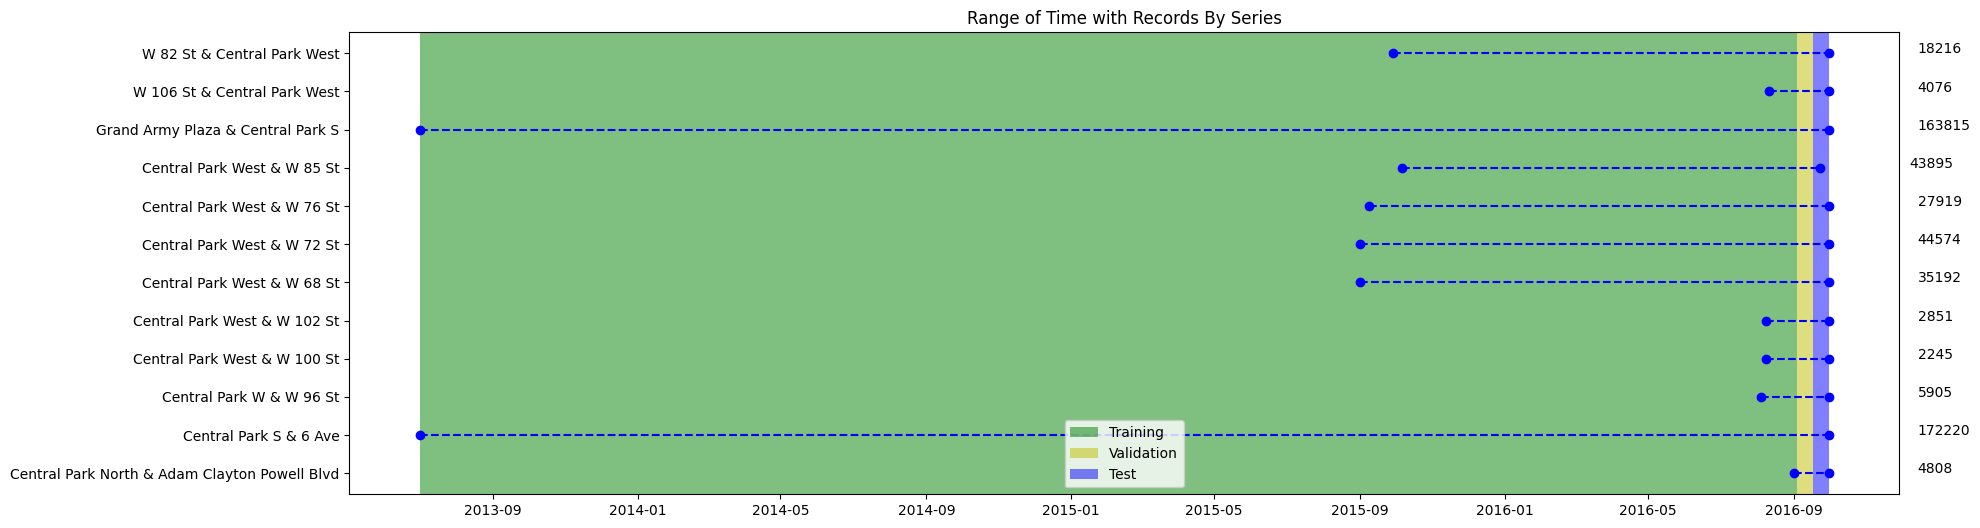

In [27]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records By Series')
plt.axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.5, label = 'Training')
plt.axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.5, label = 'Validation')
plt.axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.5, label = 'Test')
plt.legend(loc = 'lower center')
plt.show()

## Create BigQuery Table for Forecasting
Put it all together!

In [28]:
query = f"""
    CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped` AS
    SELECT *,
       CASE
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {FORECAST_TEST_LENGTH} {FORECAST_GRANULARITY}) THEN "TEST"
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {FORECAST_TEST_LENGTH} + {FORECAST_VALIDATE_LENGTH} {FORECAST_GRANULARITY}) THEN "VALIDATE"
           ELSE "TRAIN"
       END AS {SPLIT_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
job = bq.query(query)
job.result()
(job.ended-job.started).total_seconds()

4.193

In [29]:
print(f'Review The Prepped Data in The BigQuery Console:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!4m3!1s{BQ_PROJECT}!2s{BQ_DATASET}!3s{BQ_TABLE}_prepped&pli=1')

Review The Prepped Data in The BigQuery Console:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!4m3!1sstatmike-mlops-349915!2sapplied_forecasting!3sforecasting-data_prepped&pli=1


## Review Forecasting Data

In [30]:
query = f"""
    SELECT 
        {SERIES_COLUMN},
        COUNTIF({SPLIT_COLUMN} = 'TRAIN') as TRAIN,
        COUNTIF({SPLIT_COLUMN} = 'VALIDATE') as VALIDATE,
        COUNTIF({SPLIT_COLUMN} = 'TEST') as TEST,
        sum({TARGET_COLUMN}) as {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
splitCounts = bq.query(query).to_dataframe()
splitCounts.head(viz_limit)

,start_station_name,TRAIN,VALIDATE,TEST,num_trips
0,Central Park North & Adam Clayton Powell Blvd,2,14,14,4808
1,Central Park S & 6 Ave,1149,14,14,172220
2,Central Park W & W 96 St,30,14,14,5905
3,Central Park West & W 100 St,26,14,14,2245
4,Central Park West & W 102 St,26,14,14,2851
5,Central Park West & W 68 St,331,14,14,35192
6,Central Park West & W 72 St,334,14,13,44574
7,Central Park West & W 76 St,327,14,14,27919
8,Central Park West & W 85 St,324,14,7,43895
9,Grand Army Plaza & Central Park S,1152,14,13,163815


Totals by data split:

In [31]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum()

TRAIN       4055
VALIDATE     168
TEST         159
dtype: int64

Overall total:

In [32]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum().sum()

4382

Visualize days of data available for forecasting at each series:

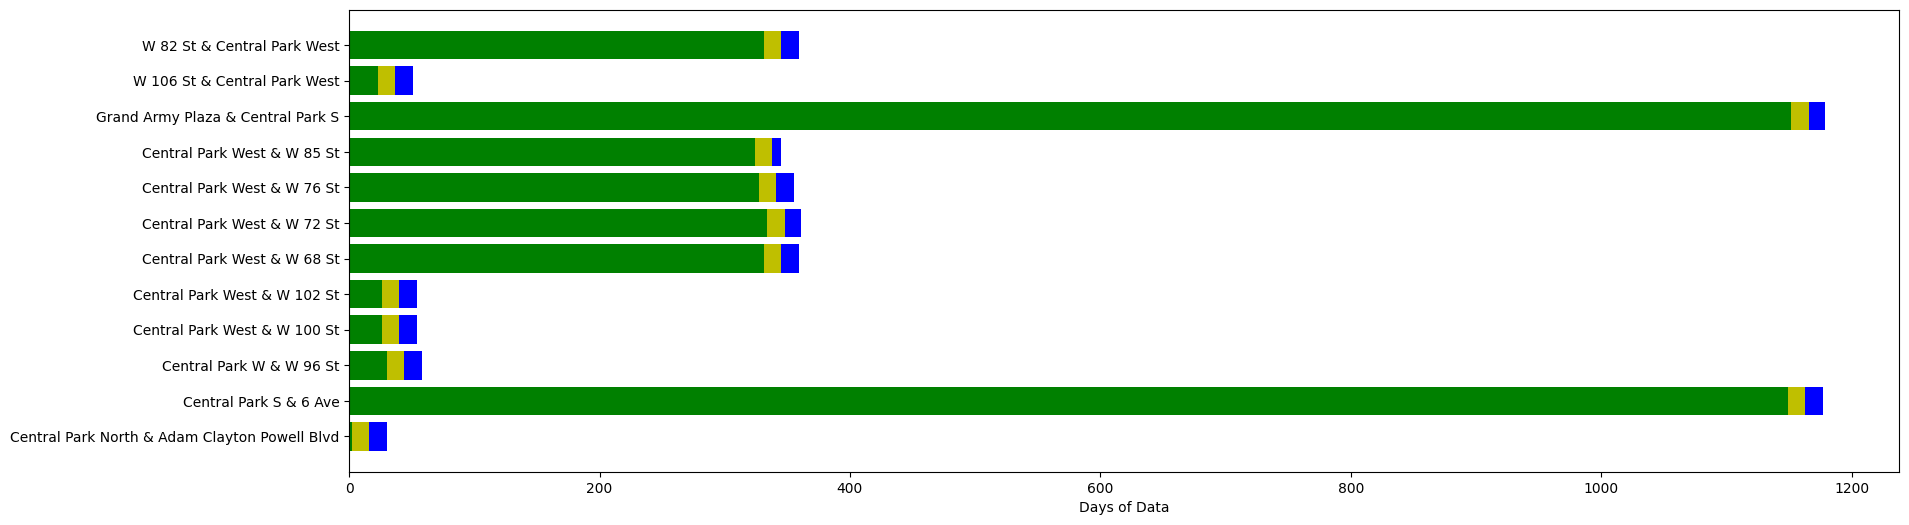

In [33]:
tempsplitCounts = splitCounts.iloc[0:viz_limit]
plt.figure(figsize=(20,6))
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TRAIN'], color = 'g')
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['VALIDATE'], color = 'y', left = tempsplitCounts['TRAIN'])
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TEST'], color = 'b', left = tempsplitCounts['TRAIN'] + tempsplitCounts['VALIDATE'])
plt.xlabel('Days of Data')
plt.show()

## Validation Check: Extract dates for splits from source

In [34]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY {SPLIT_COLUMN}
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


## Validation Check: Duplicate Dates in Series?
Are there any series with data for duplicate dates?

In [35]:
query = f"""
    WITH
        DAYS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, count(*) as records
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        )
    SELECT *
    FROM DAYS
    WHERE records > 1
"""
bq.query(query).to_dataframe()

,start_station_name,starttime,records


## Time Series Review

In [36]:
query = f"""
    SELECT 
        {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}, {SPLIT_COLUMN},
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()

### Plot Time Series

Create an interactive chart for review individual time series (bike stations) and scrolling through the time range by using [Plotly](https://plotly.com/python/):

In [61]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] + COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
    
    # which button to show:
    ff = 0 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

**Example Visual**

The visual above is dynamic with selectable ranges for the timeframe and a drop down to select individual time series.  Load this notebook in a view like Jupyter or VSCode to interact with it.  A static version is displayed below as an example:

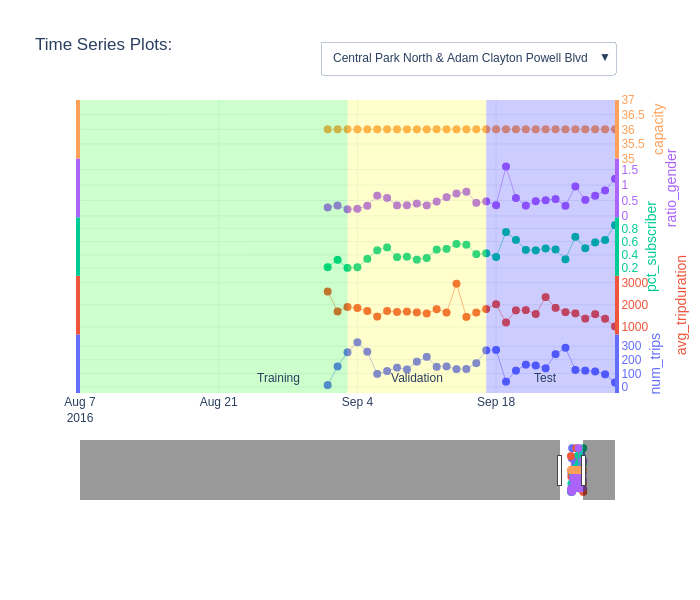

In [62]:
fig.show('png')

---
## Remove Resources
see notebook "99 - Cleanup"